[View in Colaboratory](https://colab.research.google.com/github/vincentei/predict_power_prices/blob/master/AR_model_power_prices.ipynb)

In [0]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

In [0]:
needUpload = False

In [0]:
if needUpload == True:
  from google.colab import files

  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

In [0]:
# import the data
df = pd.read_csv('prices.csv')

In [101]:
# convert to datetime
df['deliverydate'] = pd.to_datetime(df['deliverydate'],format = '%d-%m-%Y %H:%M:%S')
df['deliverydate'] = df['deliverydate'].dt.tz_localize('Europe/Amsterdam',ambiguous='infer')
df.head(2)

,deliverydate,price
0,2010-01-01 00:00:00+01:00,13.20
1,2010-01-01 01:00:00+01:00,13.14


In [102]:
a = df['deliverydate'] == dt.datetime(2014,6,2,0,0)
df[a].index.item()

38713

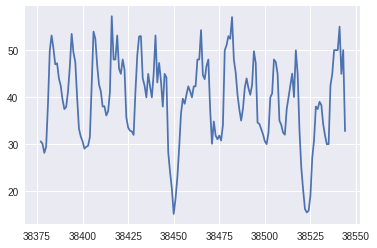

In [103]:
# plot 1 week of power prices
a = 38377
plt.plot(df['price'][a:a + 168])

In [0]:
# make lags
lags = [1,2,3,7,14] # number of days

for i in lags:
        col_name = 'lag' + str(i*24)
        df[col_name] = df['price'].shift(i*24)


In [105]:
idx = [0,1,23,24,25]
df.loc[idx]

,deliverydate,price,lag24,lag48,lag72,lag168,lag336
0,2010-01-01 00:00:00+01:00,13.20,NaN,NaN,NaN,NaN,NaN
1,2010-01-01 01:00:00+01:00,13.14,NaN,NaN,NaN,NaN,NaN
23,2010-01-01 23:00:00+01:00,31.06,NaN,NaN,NaN,NaN,NaN
24,2010-01-02 00:00:00+01:00,26.75,13.20,NaN,NaN,NaN,NaN
25,2010-01-02 01:00:00+01:00,24.25,13.14,NaN,NaN,NaN,NaN


In [106]:
# remove rows with NaN
df.dropna(axis=0, how='any',inplace=True)
df.reset_index(drop=True,inplace=True)
df.head(2)

,deliverydate,price,lag24,lag48,lag72,lag168,lag336
0,2010-01-15 00:00:00+01:00,40.3,38.72,34.93,41.84,39.5,13.20
1,2010-01-15 01:00:00+01:00,37.5,36.50,31.78,37.54,38.8,13.14


In [0]:
# split in train and test
idx = (df['deliverydate'].dt.year<=2016) & (df['deliverydate'].dt.year>=2014)

df_train = df.loc[idx].reset_index(drop=True)
df_test = df.loc[~idx].reset_index(drop=True)

In [108]:
df_test.head(2)

,deliverydate,price,lag24,lag48,lag72,lag168,lag336
0,2010-01-15 00:00:00+01:00,40.3,38.72,34.93,41.84,39.5,13.20
1,2010-01-15 01:00:00+01:00,37.5,36.50,31.78,37.54,38.8,13.14


In [0]:
# select features from df
features = ['lag24','lag48','lag168','lag336']

X_train = df_train[features]
y_train = df_train['price']

In [110]:
# fit the model
lm = LinearRegression()  
lm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [0]:
# Make predictions using the testing set
X_test = df_test[features]
y_pred = lm.predict(X_test)

In [112]:
# calc the mean absolute error
mean_absolute_error(df_test['price'], y_pred)

5.517704927563496

## Make model per weekday

In [0]:
df_test['pred'] = None

for i in [0,1,2,3,4,5,6]:
#for i in [0]:
  idx = df_train['deliverydate'].dt.weekday == i
  idx_test = df_test['deliverydate'].dt.weekday == i
  
  X_train = df_train.loc[idx,features]
  y_train = df_train.loc[idx,'price']
  
   # fit the model
  lm = LinearRegression()  
  lm.fit(X_train, y_train) 
  
  # Make predictions using the testing set
  X_test = df_test.loc[idx_test,features]
  y_pred = lm.predict(X_test)
  df_test.loc[idx_test,'pred'] = y_pred
  


In [114]:
# calc the mean absolute error
mean_absolute_error(df_test['pred'], df_test['price'])

5.166273463673231